In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import real, imag
from crccheck.crc import Crc24Ble
from scipy import signal
from gnuradio import digital
from gnuradio import gr
from gnuradio import blocks

%matplotlib widget

def plot_freq(x, fs):
    f, psd = signal.periodogram(x, fs=fs, window="hann", return_onesided=False)
    f = np.fft.fftshift(f)
    psd = np.fft.fftshift(psd)
    plt.plot(f, 10 * np.log10(psd))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.grid()

def search_sequence(arr, seq):
    Na, Nseq = arr.size, seq.size
    r_seq = np.arange(Nseq)
    M = (arr[np.arange(Na-Nseq+1).reshape(-1, 1) + r_seq] == seq).all(1)
    if M.any() > 0:
        return np.argwhere(M > 0).reshape(-1)
    else:
        return []

def scrambling_code(channel, length):
    lfsr = np.unpackbits(np.array([channel], dtype=np.ubyte))
    lfsr[1] = 1
    lfsr = lfsr[1:]
    out = np.zeros(length * 8, dtype=np.ubyte)
    for i in range(length * 8):
        out[i] = lfsr[6]
        lfsr[6] = lfsr[5]
        lfsr[5] = lfsr[4]
        lfsr[4] = out[i] ^ lfsr[3]
        lfsr[3] = lfsr[2]
        lfsr[2] = lfsr[1]
        lfsr[1] = lfsr[0]
        lfsr[0] = out[i]
    return np.packbits(out, bitorder="little")

In [35]:
fs = 8e6
data = np.fromfile("/home/maoyachen/smb/Data/2023-01-22/1.dat", dtype=np.complex64)

In [36]:
h = signal.firwin(32, 1.5e6, window="hann", fs=fs)
data = signal.filtfilt(h, 1, data)

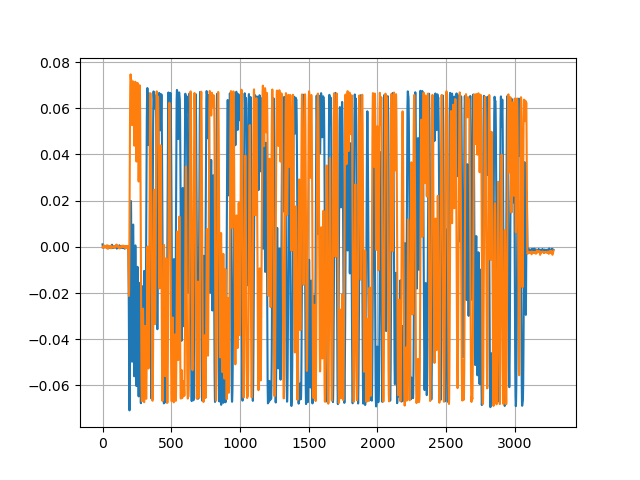

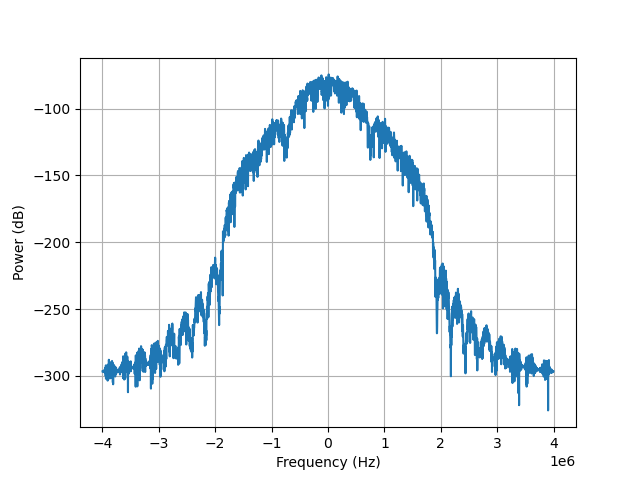

In [37]:
plt.close("all")
plt.figure()
plt.plot(real(data))
plt.plot(imag(data))
plt.grid()
plt.show()

plt.figure()
plot_freq(data, fs)
plt.show()

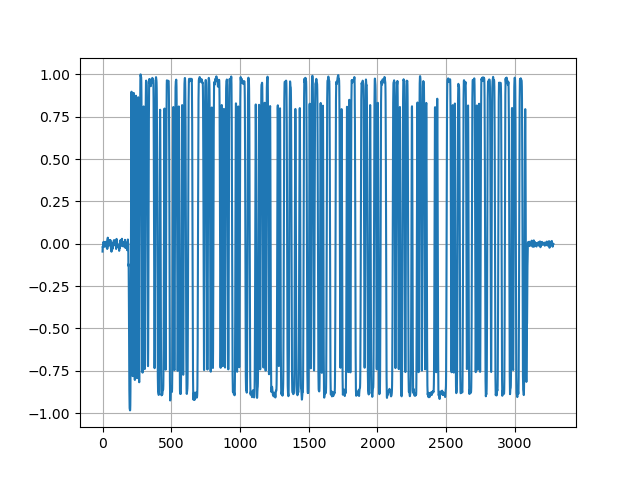

In [38]:
data1 = data[1:] * np.conjugate(data[:-1])
data1 = np.angle(data1)
data1 = np.convolve([1] * 4, data1)[1:-1] * np.abs(data)
data1 = data1 / np.max(np.abs(data1))

plt.figure()
plt.plot(data1)
plt.grid()
plt.show()

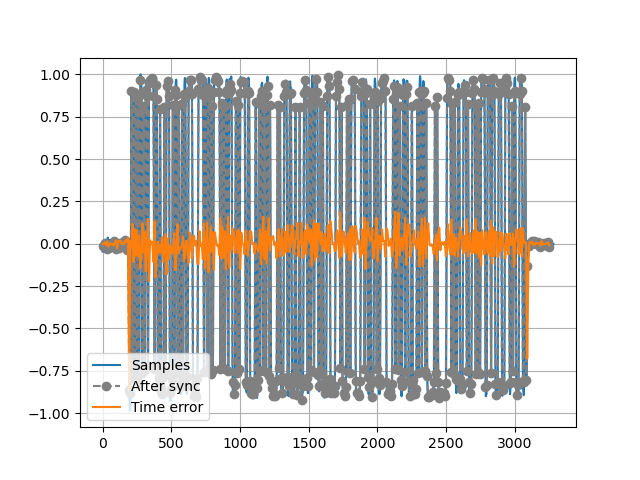

In [39]:
class SymbolSync(gr.top_block):
    def __init__(self, samples):
        gr.top_block.__init__(self)
        self.digital_symbol_sync = digital.symbol_sync_ff(
            digital.TED_MUELLER_AND_MULLER,
            sps=8,
            loop_bw=0.045,
            damping_factor=1.0,
            ted_gain=1,
            max_deviation=0.05,
            osps=1,
            slicer=digital.constellation_bpsk().base(),
            interp_type=digital.IR_MMSE_8TAP)
        self.src = blocks.vector_source_f(samples, False, 1, [])
        self.out = blocks.vector_sink_f(1, 1024)
        self.err = blocks.vector_sink_f(1, 1024)
        self.inst = blocks.vector_sink_f(1, 1024)

        self.connect((self.src, 0), (self.digital_symbol_sync, 0))
        self.connect((self.digital_symbol_sync, 0), (self.out, 0))
        self.connect((self.digital_symbol_sync, 1), (self.err, 0))
        self.connect((self.digital_symbol_sync, 2), (self.inst, 0))

sync_blk = SymbolSync(data1)
sync_blk.run()
after_symbol_sync = np.array(sync_blk.out.data())
time_error = np.array(sync_blk.err.data())
inst = np.array(sync_blk.inst.data())

t = np.cumsum(inst) - 6

plt.figure()
plt.plot(np.arange(len(data1)), data1)
plt.plot(t, after_symbol_sync, "--o", color="grey")
plt.plot(t, time_error)
plt.legend(["Samples", "After sync", "Time error"])
plt.grid()
plt.show()

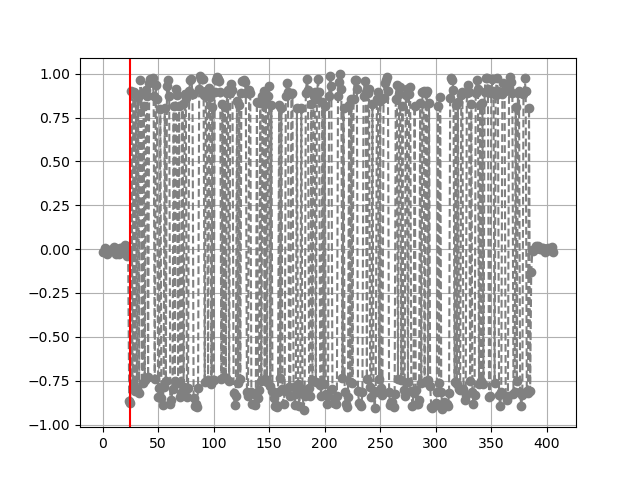

In [40]:
data2 = after_symbol_sync > 0


pkt_start = search_sequence(data2, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]))
data2 = data2[pkt_start[0]:]

plt.figure()
plt.plot(after_symbol_sync, "--o", color="grey")
for i in pkt_start:
    plt.axvline(i, color="red")
plt.grid()
plt.show()

In [41]:
def hexdump(bytes_input, width=16):
    current = 0
    end = len(bytes_input)
    result = ""
    while current < end:
        result += "%08x: " % (current // width)
        byte_slice = bytes_input[current : current + width]
        for b in byte_slice:
            result += "%02x " % b
        for _ in range(width - len(byte_slice)):
            result += " " * 3
        result += " "
        for b in byte_slice:
            if (b >= 32) and (b < 127):
                result += chr(b)
            else:
                result += "."
        result += "\n"
        current += width
    return result

buf = np.packbits(data2, bitorder="little")
print(hexdump(buf))

00000000: aa d6 be 89 8e 96 e6 c1 b7 f5 ab 1d f5 19 a4 b5  ................
00000001: 40 71 46 c4 69 a7 38 78 a1 1e dc c4 f2 81 2d 1b  @qF.i.8x......-.
00000002: a1 2d a0 00 af 8c 8b ab e7 8e e3 69 9c f0 5d 19  .-.........i..].



In [42]:
pdu = buf[5:]
pdu = pdu ^ scrambling_code(38, len(pdu))
pdu_len = pdu[1] + 2
pdu = pdu[:pdu_len + 3]

crc = Crc24Ble.calc(pdu[:-3])

print(hexdump(pdu))
print(hex(crc))

00000000: 40 23 85 97 ac 75 fc 7a 02 01 1a 02 0a 08 09 09  @#...u.z........
00000001: 4c 5a 5a 31 32 33 34 35 0c ff 4c 00 10 07 66 1f  LZZ12345..L...f.
00000002: f9 ba ba af 18 94 91 7f                          ........

0x7f9194
